# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2)

In [1]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = 'lab2data/train.p'
testing_file = 'lab2data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

# Set flags for feature engineering.  This will prevent you from skipping an important step.
is_features_yuv = False
is_features_y_normal = False
is_labels_encod = False
is_labels_float32 = False
has_new_datasets = False

In [2]:
### To start off let's do a basic data summary.
# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
classes = {}
for labelinTraining in y_train:
    classes[labelinTraining] = classes.get(labelinTraining, 0) + 1
n_classes = len(list(classes))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [3]:
#importing some useful packages for plotting and visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

#import sklearn functions for preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

#import pandas for csv file import
#NOTE: install pandas in your environment!
#conda install pandas
import pandas as pd

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# get the label description from the CSV file.
classLabelList = pd.read_csv('signnames.csv')

# Analyze Max and Min sizes (number of pixels) of the original image
sizeStats = pd.DataFrame(train['sizes'])
print("Sizes Stats:")
print(sizeStats.describe())

originalSizes = {}
mostCommonCount = 0
mostCommonSize = 0
for i in range(len(train['sizes'])):
    # for each size
    sizes = train['sizes'][i]
    
    # create a pixel hash
    numpixelsStr = str(int(sizes[0])*int(sizes[1]))
    
    # try to see if there is a hash hit
    sizeInstance = originalSizes.get(numpixelsStr, {'count': 0})
    
    # add to the count
    count = sizeInstance['count'] + 1
    
    # put in the last Index
    originalSizes[numpixelsStr] = {'lastIdx':i, 'count': count, 'size':sizes}
    
    # update most common size
    if count > mostCommonCount:
        mostCommonCount = count
        mostCommonSize = originalSizes[numpixelsStr]
    
# get the list of sizes and sort them
sortedSizes = np.array(list(originalSizes.keys()), np.int32)
sortedSizes.sort()

# get the unique number of original picture sizes and the min and max last instance
n_sizes = len(sortedSizes)
minSize = sortedSizes[0]
maxSize = sortedSizes[n_sizes-1]

# print the stats
print("\nNumber of unique original sizes in training set: ", n_sizes)


Sizes Stats:
                  0             1
count  39209.000000  39209.000000
mean      50.328930     50.835880
std       23.115423     24.306933
min       25.000000     25.000000
25%       35.000000     35.000000
50%       43.000000     43.000000
75%       58.000000     58.000000
max      225.000000    243.000000

Number of unique original sizes in training set:  2034


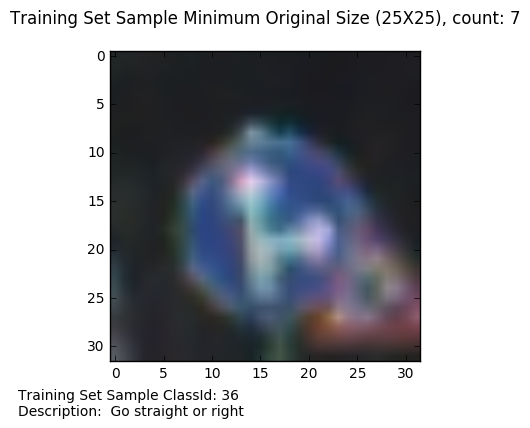

In [5]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# draw the min size picture
size = originalSizes[str(minSize)]['size']
count = originalSizes[str(minSize)]['count']
index = originalSizes[str(minSize)]['lastIdx']
classId = y_train[index]
description = classLabelList[classLabelList.ClassId==classId].SignName.to_string(header=False,index=False)
fg = plt.figure()
fg.text(0.1,-0.01,'Training Set Sample ClassId: %d\nDescription:  %s'%(classId,description))
plt.title('Training Set Sample Minimum Original Size (%dX%d), count: %d\n'%(size[0], size[1],count))
plt.imshow(X_train[index])



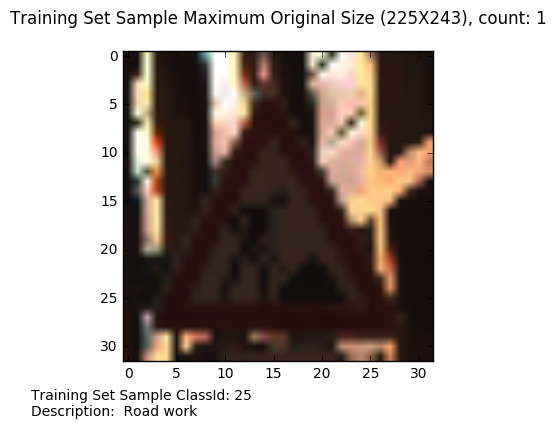

In [6]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# draw the max size picture
size = originalSizes[str(maxSize)]['size']
count = originalSizes[str(maxSize)]['count']
index = originalSizes[str(maxSize)]['lastIdx']
classId = y_train[index]
description = classLabelList[classLabelList.ClassId==classId].SignName.to_string(header=False,index=False)
fg = plt.figure()
fg.text(0.1,-0.01,'Training Set Sample ClassId: %d\nDescription:  %s'%(classId,description))
plt.title('Training Set Sample Maximum Original Size (%dX%d), count: %d\n'%(size[0], size[1],count))
plt.imshow(X_train[index])


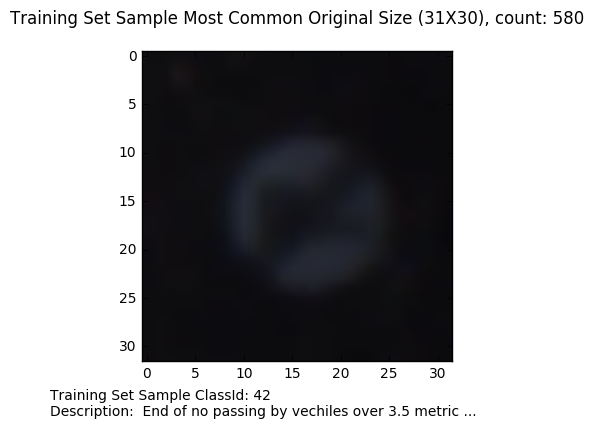

In [7]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# draw the max size picture
size = mostCommonSize['size']
count = mostCommonSize['count']
index = mostCommonSize['lastIdx']
classId = y_train[index]
description = classLabelList[classLabelList.ClassId==classId].SignName.to_string(header=False,index=False)
fg = plt.figure()
fg.text(0.1,-0.01,'Training Set Sample ClassId: %d\nDescription:  %s'%(classId,description))
plt.title('Training Set Sample Most Common Original Size (%dX%d), count: %d\n'%(size[0], size[1],count))
plt.imshow(X_train[index])


In [8]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# x,y plot of the image locations
labelsStats = pd.DataFrame(y_train)
print("Labels Stats:")
print(labelsStats.describe())

labelsInfo = {}
mostCommonCount = 0
mostCommonLabel = 0
for i in range(len(y_train)):
    # for each label
    label = str(y_train[i])
    
    # try to see if there is a hash hit
    labelInstance = labelsInfo.get(label, {'count': 0})
    
    # add to the count
    count = labelInstance['count'] + 1
    
    # put in the last Index
    labelsInfo[label] = {'lastIdx':i, 'count': count, 'label':int(label)}
    
    # update most common size
    if count > mostCommonCount:
        mostCommonCount = count
        mostCommonSize = labelsInfo[label]
    
# get the list of counts and sort them
sortedLabels = list(labelsInfo.keys())

def compare_count(label):
    return labelsInfo[label]['count']

sortedLabels.sort(key=compare_count)

# get the unique number of original picture sizes and the min and max last instance
n_labels = len(sortedLabels)
minLabel = sortedLabels[0]
maxLabel = sortedLabels[n_labels-1]


# print the stats
print("\nNumber of unique labels in training set: ", n_labels)
print("\nDistribution of training set labels:")
for i in range(n_labels):
    classId = labelsInfo[str(i)]['label']
    index = labelsInfo[str(i)]['lastIdx']
    count = labelsInfo[str(i)]['count']
    description = classLabelList[classLabelList.ClassId==classId].SignName.to_string(header=False,index=False)
    print("Training Set count: {0:4d}  ClassId: {1:02d}  Description: {2}".format(count, classId, description))


Labels Stats:
                  0
count  39209.000000
mean      15.788390
std       12.013238
min        0.000000
25%        5.000000
50%       12.000000
75%       25.000000
max       42.000000

Number of unique labels in training set:  43

Distribution of training set labels:
Training Set count:  210  ClassId: 00  Description: Speed limit (20km/h)
Training Set count: 2220  ClassId: 01  Description: Speed limit (30km/h)
Training Set count: 2250  ClassId: 02  Description: Speed limit (50km/h)
Training Set count: 1410  ClassId: 03  Description: Speed limit (60km/h)
Training Set count: 1980  ClassId: 04  Description: Speed limit (70km/h)
Training Set count: 1860  ClassId: 05  Description: Speed limit (80km/h)
Training Set count:  420  ClassId: 06  Description: End of speed limit (80km/h)
Training Set count: 1440  ClassId: 07  Description: Speed limit (100km/h)
Training Set count: 1410  ClassId: 08  Description: Speed limit (120km/h)
Training Set count: 1470  ClassId: 09  Description: No p

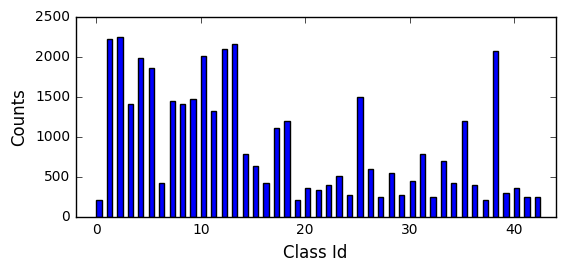

In [9]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# Plot bar graph of class id count distribution
x = range(0, n_labels)
y = [labelsInfo[str(n)]['count'] for n in x]
fg = plt.figure()
ax1 = fg.add_axes((.1,.4,.8,.5))
ax1.bar(x,y,0.5)
plt.xlim((-2.0, 44))
plt.ylabel("Counts", fontsize = 12)
plt.xlabel("Class Id", fontsize = 12)
plt.show()


In [10]:
# print the stats
print("\nDistribution of training set labels in sorted count order:")
for i in range(n_labels):
    classId = labelsInfo[str(sortedLabels[i])]['label']
    index = labelsInfo[str(sortedLabels[i])]['lastIdx']
    count = labelsInfo[str(sortedLabels[i])]['count']
    description = classLabelList[classLabelList.ClassId==classId].SignName.to_string(header=False,index=False)
    print("Training Set count: {0:4d}  ClassId: {1:02d}  Description: {2}".format(count, classId, description))



Distribution of training set labels in sorted count order:
Training Set count:  210  ClassId: 00  Description: Speed limit (20km/h)
Training Set count:  210  ClassId: 19  Description: Dangerous curve to the left
Training Set count:  210  ClassId: 37  Description: Go straight or left
Training Set count:  240  ClassId: 27  Description: Pedestrians
Training Set count:  240  ClassId: 42  Description: End of no passing by vechiles over 3.5 metric ...
Training Set count:  240  ClassId: 32  Description: End of all speed and passing limits
Training Set count:  240  ClassId: 41  Description: End of no passing
Training Set count:  270  ClassId: 29  Description: Bicycles crossing
Training Set count:  270  ClassId: 24  Description: Road narrows on the right
Training Set count:  300  ClassId: 39  Description: Keep left
Training Set count:  330  ClassId: 21  Description: Double curve
Training Set count:  360  ClassId: 20  Description: Dangerous curve to the right
Training Set count:  360  ClassId: 

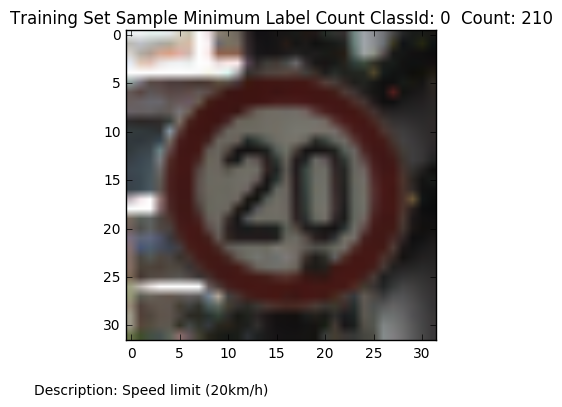

In [11]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# list minimium count for class id and draw a sample picture.
classId = labelsInfo[str(minLabel)]['label']
index = labelsInfo[str(minLabel)]['lastIdx']
count = labelsInfo[str(minLabel)]['count']
description = classLabelList[classLabelList.ClassId==classId].SignName.to_string(header=False,index=False)
fg = plt.figure()
fg.text(0.1,-0.01,'Description: %s'%(description))
plt.title('Training Set Sample Minimum Label Count ClassId: %d  Count: %d'%(classId,count))
plt.imshow(X_train[index])

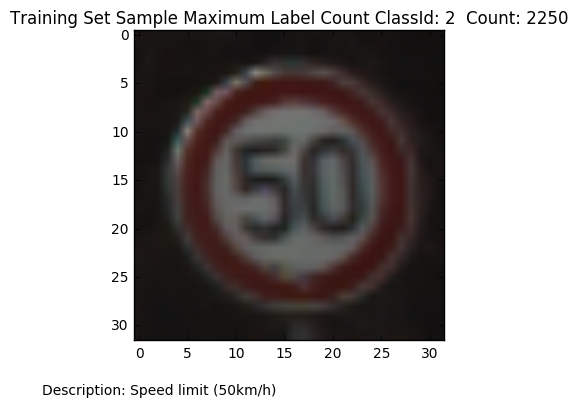

In [12]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# list maximium count for class id and draw a sample picture.
classId = labelsInfo[str(maxLabel)]['label']
index = labelsInfo[str(maxLabel)]['lastIdx']
count = labelsInfo[str(maxLabel)]['count']
description = classLabelList[classLabelList.ClassId==classId].SignName.to_string(header=False,index=False)
fg = plt.figure()
fg.text(0.1,-0.01,'Description: %s'%(description))
plt.title('Training Set Sample Maximum Label Count ClassId: %d  Count: %d'%(classId,count))
plt.imshow(X_train[index])

In [13]:
# It seems that the 'sizes' (width, height) and 'coords' (x1, y1, x2, y2) features have the same values?
# Looks like we cannot get any real information from the 'coords' feature.
allsame = True
for i in range(n_train):
    if not (train['sizes'][i].all() == train['coords'][i].all()):
        allsame = False
if allsame:
    print("train['sizes'] == train['coords']!!!\nIgnoring 'coords' feature in train dataset.\n")

allsame = True
for i in range(n_test):
    if not (test['sizes'][i].all() == test['coords'][i].all()):
        allsame = False
if allsame:
    print("test['sizes'] == test['coords']!!!\nIgnoring 'coords' feature in test dataset.\n")



train['sizes'] == train['coords']!!!
Ignoring 'coords' feature in train dataset.

test['sizes'] == test['coords']!!!
Ignoring 'coords' feature in test dataset.



----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

Features are now converted YUV!
X_train image shape:  (32, 32, 3)  of  <class 'numpy.uint8'>


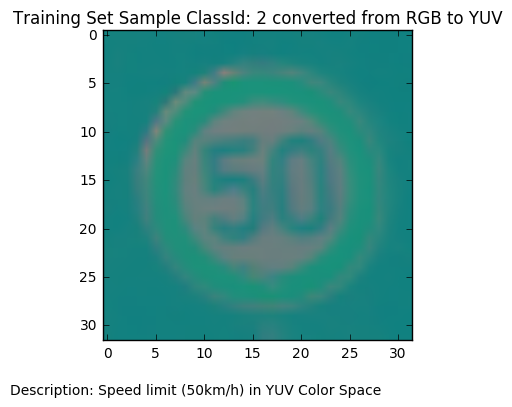

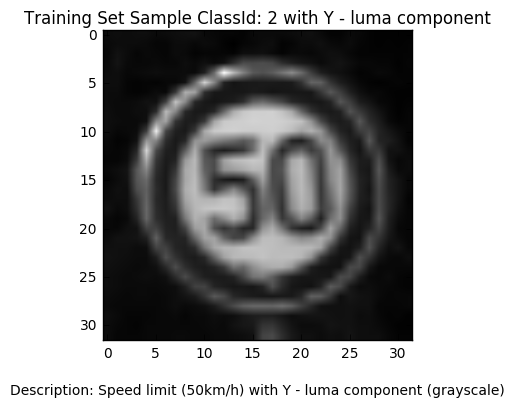

In [14]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
###
### Step 1:
### We need to condition the training and testing data.  We need to convert the color image to grey scale since
### RGB features in the traffic sign will not contribute to its classification and recognition.  We will use
### OpenCV to do the conversion as we did in the earlier Lane Line Project 1 to reduce the size of the features
### so as to allow the Stochastic Gradient Descent Machine Learning algorithm to process more relivent data to
### learn faster.  In referencing the article: http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf,
### page 2, section III. EXPERIMENTS, subsection A. Data Preparation, item 2) Pre-processing, we find 
### converting the feature RGB color space to YUV seems to improve classification and recognition, and we will
### follow this path as well.  Since our training and test features are already at 32x32 resolution, we just
### need to do the conversion to YUV color space in this step.

def RGB2YUV(image_data):
    yuv_image_data = []
    for i in range(len(image_data)):
        yuv_image_data.append(cv2.cvtColor(image_data[i], cv2.COLOR_RGB2YUV))
    return np.array(yuv_image_data)

if is_features_yuv:
    print('Nothing done.  Features are already in YUV!')
else:
    new_X_train = RGB2YUV(X_train)
    new_y_train = np.copy(y_train)
    new_X_test = RGB2YUV(X_test)
    new_y_test = np.copy(y_test)
    is_features_yuv = True
    print('Features are now converted YUV!')

# list maximium count for class id and draw a sample picture.
print('X_train image shape: ', new_X_train[index].shape, " of ", type(new_X_train[index][0][0][0]))
classId = labelsInfo[str(maxLabel)]['label']
index = labelsInfo[str(maxLabel)]['lastIdx']
description = classLabelList[classLabelList.ClassId==classId].SignName.to_string(header=False,index=False)
fg = plt.figure()
fg.text(0.1,-0.01,'Description: %s in YUV Color Space'%(description))
plt.title('Training Set Sample ClassId: %d converted from RGB to YUV'%(classId))
plt.imshow(new_X_train[index])

yuv = cv2.split(new_X_train[index])
fg = plt.figure()
fg.text(0.1,-0.01,'Description: %s with Y - luma component (grayscale)'%(description))
plt.title('Training Set Sample ClassId: %d with Y - luma component'%(classId))
plt.imshow(yuv[0], cmap='gray')


Features Y are now normalized and converted to float32!
X_train image shape:  (32, 32, 3)  of  <class 'numpy.float32'>


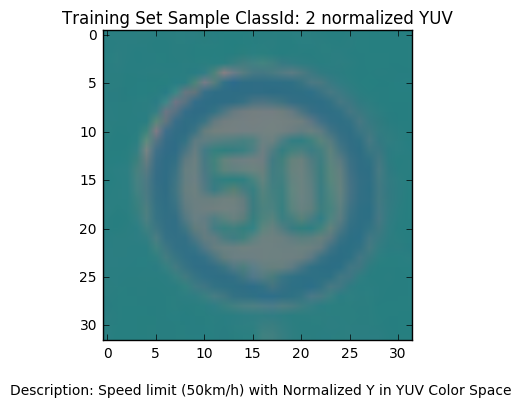

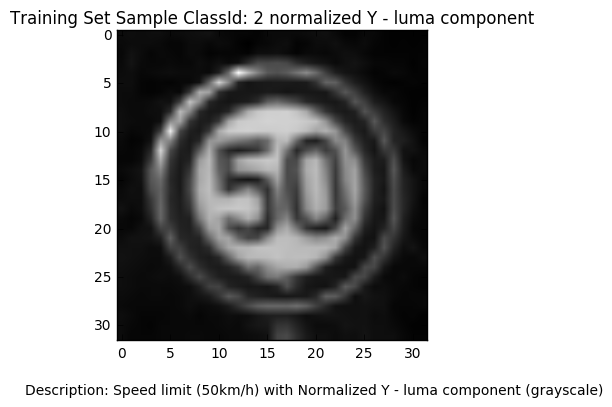

In [15]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
###
### Step 2:
### We will implement the Min-Max scaling function and apply it to the Y in the UV color space as described in
### in the article: http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf, page 2, section III.
### EXPERIMENTS, subsection A. Data Preparation, item 2) Pre-processing.  We will apply this to images we
### converted in step 1.
###
### This is needed as we did in the TensorFlow Neural Network Lab assignment to process the image into a
### well conditioned features so we are centered on a zero mean with equal variance to make it easy for
### our neural network to perform Gradient Descent faster to train its weights and biases to the given labels.
### We will also convert the features from uint8 to float32 to make it easier for GPUs to process the data
### Using their thousands of multi-cores parallel processing units in a CUDA enabled Deep Learning system.

def normalize_Y_in_YUV(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    y_min = 0
    y_max = 255
    yuv_image_data = []

    for i in range(len(image_data)):
        yuv = cv2.split(image_data[i])  
        y = np.array(yuv[0], np.float32)
        y = a + ( ( (y - y_min)*(b - a) )/( y_max - y_min ) )
        u = np.array(yuv[1], np.float32)
        v = np.array(yuv[2], np.float32)
        yuv = np.dstack((y, u, v))
        yuv_image_data.append(yuv)
    return np.array(yuv_image_data)

if is_features_y_normal:
    print('Nothing done.  Features Y are already normalized and converted to float32!')
else:
    new_X_train = normalize_Y_in_YUV(new_X_train)
    new_X_test = normalize_Y_in_YUV(new_X_test)
    is_features_y_normal = True
    print('Features Y are now normalized and converted to float32!')

# list maximium count for class id and draw a sample picture.
print('X_train image shape: ', new_X_train[index].shape, " of ", type(new_X_train[index][0][0][0]))
classId = labelsInfo[str(maxLabel)]['label']
index = labelsInfo[str(maxLabel)]['lastIdx']
description = classLabelList[classLabelList.ClassId==classId].SignName.to_string(header=False,index=False)
fg = plt.figure()
fg.text(0.1,-0.01,'Description: %s with Normalized Y in YUV Color Space'%(description))
plt.title('Training Set Sample ClassId: %d normalized YUV'%(classId))
plt.imshow(new_X_train[index])

yuv = cv2.split(new_X_train[index])
fg = plt.figure()
fg.text(0.1,-0.01,'Description: %s with Normalized Y - luma component (grayscale)'%(description))
plt.title('Training Set Sample ClassId: %d normalized Y - luma component'%(classId))
plt.imshow(yuv[0], cmap='gray')


In [16]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
###
### Step 3:
### We will apply One-Hot Encoding to our numeric traffic labels.
### This is a way to represent our labels mathematically so that we have a vector that contains as many values
### as we have classes.  The value that we want to set for the correct class is set to 1 while all others are
### set to 0.

if is_labels_encod:
    print('Nothing done.  Labels are already One-Hot encoded!')
else:
    encoder = LabelBinarizer()
    encoder.fit(new_y_train)
    new_y_train = encoder.transform(new_y_train)
    new_y_test = encoder.transform(new_y_test)
    is_labels_encod = True
    print('Labels are now One-Hot encoded!')


Labels are now One-Hot encoded!


In [17]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
###
### Step 4:
### We will change our One-Hot Encoded labels to float32 so as to allow them to be multiplied against
### the features in Tensorflow using the thousands of multi-cores parallel processing units in a CUDA
### enabled Deep Learning system.

if is_labels_float32:
    print('Nothing done!  Labels are already float32!')
else:
    new_y_train = new_y_train.astype(np.float32)
    new_y_test = new_y_test.astype(np.float32)
    is_labels_float32 = True
    print('Labels are now float32!')

Labels are now float32!


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

Generating dataset  1 ...
Generating dataset  2 ...
Generating dataset  3 ...
Generating dataset  4 ...
Generating dataset  5 ...
New datasets generated!
Original dataset sizes, training set:  39209  testing set:  12630
New generated dataset sizes, training set:  235254  testing set:  75780


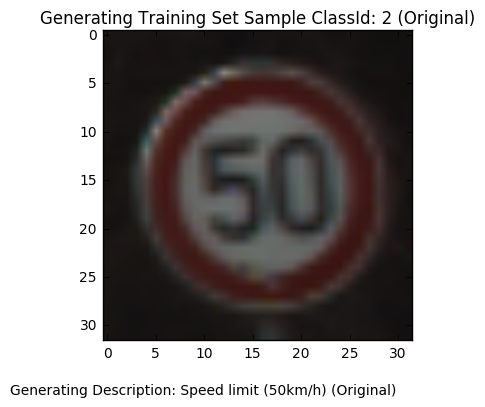

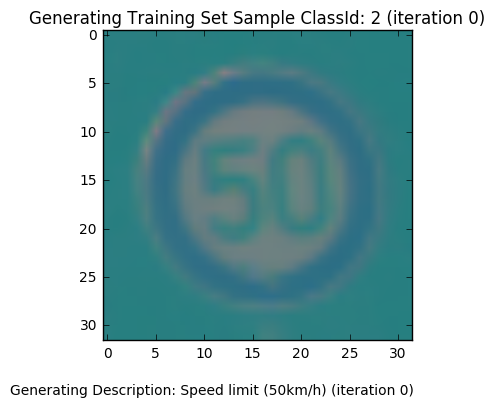

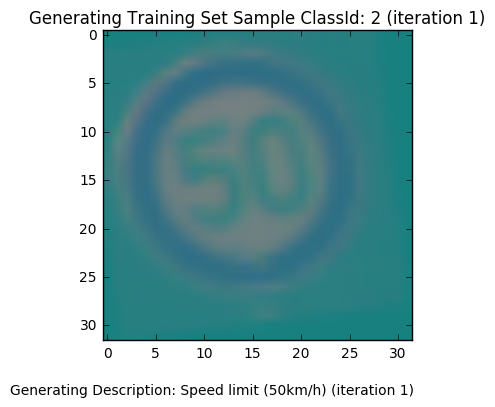

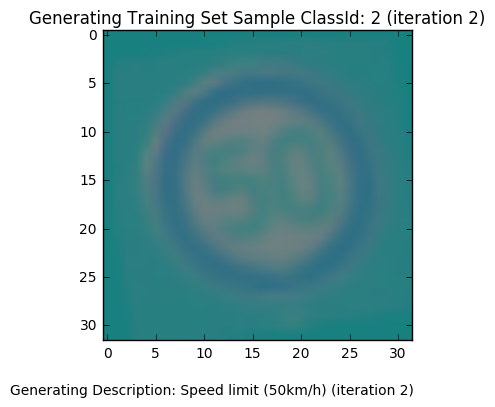

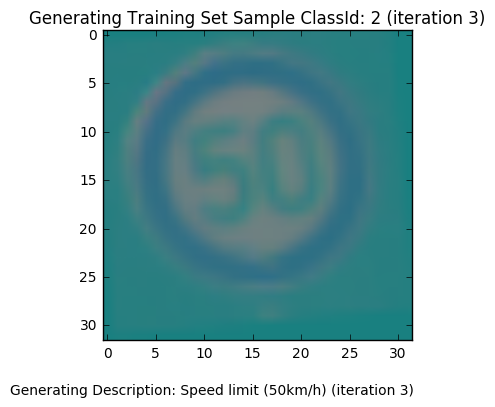

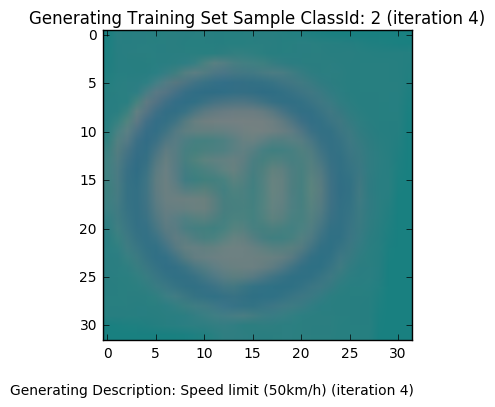

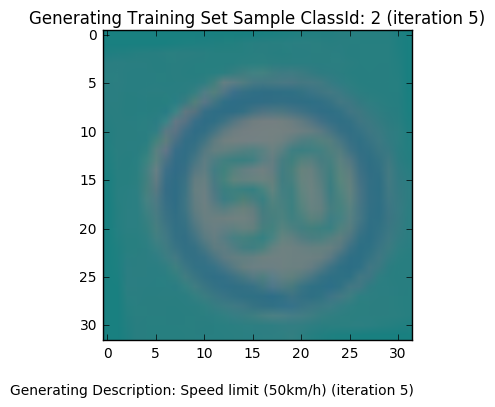

In [19]:
### Generate data additional (if you want to!)
### Feel free to use as many code cells as needed.
###
### In referencing the article: http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf,
### page 2, section III. EXPERIMENTS, subsection A. Data Preparation, item 2) Pre-processing, we find 
### that if we generate a "Jittered dataset" and add it to our original dataset, it will drop our validation
### error from around 1.31% to 1.08%.  We can follow the same procedure as described in this section, and
### generate additional 5X samples by randomly perturbed in position ([-2,2] pixels),
### in scale ([.9,1.1] ratio) and rotation ([-15,+15] degrees).  As described in the reference:
### "When a dataset does not naturally contain those deformations, adding them synthetically will yield
###  more robust learning to potential deformations in the test set."

assert is_features_yuv
assert is_features_y_normal
assert is_labels_encod
assert is_labels_float32

import random

# function to shift images x or y offsets
def shiftxy(image, xoffset, yoffset):
    rows,cols, depth = image.shape
    M = np.float32([[1,0,xoffset],[0,1,yoffset]])
    res = cv2.warpAffine(image,M,(cols,rows))
    assert (res.shape[0] == 32)
    assert (res.shape[1] == 32)
    return res
    
# function to rotate images by given degrees
def rotate(image, degree):
    rows, cols, depth = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), degree, 1)
    res = cv2.warpAffine(image, M, (cols,rows))
    assert (res.shape[0] == 32)
    assert (res.shape[1] == 32)
    return res
    
# function to resize the image
def scale(image, ratio):
    rows, cols, depth = image.shape
    newrows = int(ratio*rows)
    newcols = int(ratio*cols)
    res = cv2.resize(image, (newrows, newcols), interpolation=cv2.INTER_AREA)
    if newrows*newcols > 1024:
        # crop the image back to 32x32
        cropped = res[1:33, 1:33]
        res = cropped
    else:
        if newrows*newcols < 1024:
            tmpimage = np.copy(image)*0.0
            xoffset = (32-newcols)-int(random.random()*(32-newcols))
            yoffset = (32-newrows)-int(random.random()*(32-newrows))
            tmpimage[xoffset:newrows+xoffset, yoffset:newcols+yoffset] = res
            res = tmpimage
    assert (res.shape[0] == 32)
    assert (res.shape[1] == 32)
    return res

# function to generate a new set of training or test dataset by building a jittered dataset.
def generateNewSet(image_data):
    new_image_data = np.copy(image_data)
    for i in range(len(new_image_data)):
        x = int(random.random() * 4) - 2
        y = int(random.random() * 4) - 2
        degree = int(random.random()*30.0)-15
        ratio = random.random()*0.2 + 0.9
        new_image_data[i] = scale(rotate(shiftxy(new_image_data[i],x,y),degree),ratio)
    return normalize_Y_in_YUV(RGB2YUV(new_image_data))

if has_new_datasets:
    print('Nothing done!  New datasets have already been generated!')
else:
    for x in range(5):
        print("Generating dataset ", x+1, "...")
        new_X_train = np.append(new_X_train, generateNewSet(X_train), axis=0)
        new_y_train = np.append(new_y_train, y_train)
        new_X_test = np.append(new_X_test, generateNewSet(X_test), axis=0)
        new_y_test = np.append(new_y_test, y_test)
    has_new_datasets = True
    print("New datasets generated!")

print("Original dataset sizes, training set: ", len(X_train), " testing set: ", len(X_test))
print("New generated dataset sizes, training set: ", len(new_X_train), " testing set: ", len(new_X_test))

# list maximium count for class id and draw a sample picture.
classId = labelsInfo[str(maxLabel)]['label']
indexoffset = labelsInfo[str(maxLabel)]['lastIdx']
description = classLabelList[classLabelList.ClassId==classId].SignName.to_string(header=False,index=False)
fg = plt.figure()
fg.text(0.1,-0.01,'Generating Description: %s (Original)'%(description))
plt.title('Generating Training Set Sample ClassId: %d (Original)'%(classId))
plt.imshow(X_train[indexoffset])
for i in range(6):
    index = n_train*i+indexoffset
    fg = plt.figure()
    fg.text(0.1,-0.01,'Generating Description: %s (iteration %d)'%(description, i))
    plt.title('Generating Training Set Sample ClassId: %d (iteration %d)'%(classId, i))
    plt.imshow(new_X_train[index])
    yuv = cv2.split(new_X_train[index])



In [ ]:
### Split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.



### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.